In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v25
from Resources.Game import *
from Resources.TS_ModelGuided import *
from Resources.TS_ModelGuided_MCRollout import *
from Resources.TS_ModelGuided_SensAnalysis import *

from test_games import test_games


##### Setup Model

In [2]:
model = Model_v25()
model.eval()
model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v25/model_2000_batches'))

<All keys matched successfully>

Settings

In [3]:
def factors_short_to_long(short):
    # set parameters for material and gradients to zero
    return [short[0], 0.0, short[1], short[2], 0.0, 0.0, short[3]]

def factors_mid_to_long(mid):
    # set parameter for material to zero
    return [mid[0], 0.0, mid[1], mid[2], mid[3], mid[4], mid[5]]

In [4]:
# factors:
# factor_wins=1, factor_mat=0, factor_value_sum=0.5, factor_value_indi=0.5, 
# factor_grad_sum=0.1, factor_grad_indi=0.1, factor_explore=1e-3,

factors_1 = [1, 0, 0.5, 0.5, 0.0, 0.0, 0.0001]
factors_2 = [1, 0, 0.5, 0.5, 0.0, 0.0, 10]

factors = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # factor wins

# when using only [wins, value_sum, value_indi, explore]
# --> [0.23509465 0.97146549 0.01327048 0.02844645]

n_games = 3
tmax = 0.5

In [5]:
# Small RL loop, pseudo SGD
factors = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
factors = np.array(factors)
factors = 1/np.linalg.norm(factors) * factors 
print(factors)

[0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]


In [10]:
# small RL loop to find best factor hyperparameters 

factor_hist = []

while True:

    print(len(factor_hist), factors)

    # t0 = time.time()

    for i in range(6):

        # print(factors)
        factors_test = factors.copy()
        factors_test[i] *= 1.1

        wins_1, draws, wins_2 = test_games(n_games, model, tmax, factors_mid_to_long(factors), 
                                        factors_mid_to_long(factors_test))
        
        if wins_1 > wins_2:
            factors[i] *= 1/1.1
        elif wins_2 > wins_1:
            factors[i] *= 1.1

    factors = 1/np.linalg.norm(factors) * factors 
    
    factor_hist.append(factors.copy())

    # print('duration: ', time.time() - t0)

0 [0.40824829 0.40824829 0.40824829 0.40824829 0.40824829 0.40824829]
1 [0.37544934 0.41299428 0.41299428 0.4542937  0.41299428 0.37544934]
2 [0.33234974 0.40214319 0.44235751 0.48659326 0.40214319 0.36558472]
3 [0.32142085 0.38891922 0.47059226 0.47059226 0.38891922 0.38891922]
4 [0.29186175 0.38846799 0.51705089 0.47004627 0.35315272 0.38846799]
5 [0.28531769 0.37975785 0.5054577  0.5054577  0.34523441 0.37975785]
6 [0.25376023 0.33775487 0.4945069  0.54395759 0.33775487 0.40868339]
7 [0.24965597 0.3322921  0.48650886 0.58867573 0.3322921  0.36552131]
8 [0.25208305 0.30502049 0.49123855 0.59439864 0.33552254 0.36907479]
9 [0.23564215 0.31363971 0.50511989 0.61119506 0.31363971 0.34500368]
10 [0.25753363 0.34277727 0.45623654 0.60725084 0.3116157  0.37705499]
11 [0.24531325 0.35916312 0.43458738 0.63627938 0.29682903 0.35916312]
12 [0.25006973 0.36612709 0.44301378 0.64861648 0.2750767  0.33284281]
13 [0.25732896 0.34250485 0.45587396 0.66744506 0.25732896 0.31136805]
14 [0.25937423 0

In [29]:
factor_hist = []
factors = [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1e-3]
# [wins, value sum, value ind, grad sum, grad ind, exploration]
factors = np.array(factors)
for factor_i in range(7):
    if factor_i == 1:
        continue
    torch.save(factors[factor_i], 'latest factor_{}'.format(factor_i))
# factors = 1/np.linalg.norm(factors) * factors 
print(factors)

[1.    0.    1.    1.    0.    0.    0.001]


In [26]:
# small RL loop to find best factor hyperparameters 
# Threading to run test games in parallel

import threading

from test_games import test_games, run_test_games

while True:

    print(factors)

    t0 = time.time()

    factor_hist.append(factors.copy())

    process_list = []

    for i in range(6):

        # print(factors)

        factors_test = factors.copy()

        if i == 3 or i == 4: # grad based factors might switch sign
            factors_test[i] += 0.01
        else: # for other factors find proper scale
            factors_test[i] *= 1.1

        arg_list = [1, model, 1, factors_mid_to_long(factors), 
                                        factors_mid_to_long(factors_test)]

        process_list.append(threading.Thread(target=run_test_games, 
                                           args=('Process '+str(i), arg_list)))
    
    print('start processes')

    for process in process_list:
        process.start()

    print('wait for processes')
    
    for process in process_list:
        process.join()
    
    print('evaluate results')

    for i in range(6):

        wins_1, draws, wins_2 = torch.load('temp Process '+str(i))

        if i == 3 or i == 4:

            if wins_1 > wins_2:
                factors[i] -= 0.01
            elif wins_2 > wins_1:
                factors[i] += 0.01

        else:
            if wins_1 > wins_2:
                factors[i] *= 1/1.1
            elif wins_2 > wins_1:
                factors[i] *= 1.1

    # factors = 1/np.linalg.norm(factors) * factors 

    torch.save(factors, 'factor saves/factors save '+str(len(factor_hist)))

    print('duration: ', time.time() - t0)

[1.    1.    1.    0.    0.    0.001]
start processes
wait for processes
Process 1 (0, 0, 1)
Process 2 (0, 0, 1)
Process 3 (0, 0, 1)
Process 5 (1, 0, 0)
Process 0 (1, 0, 0)
Process 4 (0, 1, 0)
evaluate results
duration:  205.93771290779114
[9.09090909e-01 1.10000000e+00 1.10000000e+00 1.00000000e-02
 0.00000000e+00 9.09090909e-04]
start processes
wait for processes
Process 3 (0, 0, 1)
Process 5 (0, 1, 0)
Process 4 (0, 0, 1)
Process 0 (0, 1, 0)
Process 2 (0, 1, 0)
Process 1 (0, 0, 1)
evaluate results
duration:  287.465341091156
[9.09090909e-01 1.21000000e+00 1.10000000e+00 2.00000000e-02
 1.00000000e-02 9.09090909e-04]
start processes
wait for processes
Process 0 (0, 0, 1)
Process 3 (1, 0, 0)
Process 1 (0, 0, 1)
Process 2 (0, 1, 0)
Process 5 (0, 1, 0)
Process 4 (0, 1, 0)
evaluate results
duration:  265.88872814178467
[1.00000000e+00 1.33100000e+00 1.10000000e+00 1.00000000e-02
 1.00000000e-02 9.09090909e-04]
start processes
wait for processes


KeyboardInterrupt: 

Process 1 (1, 0, 0)
Process 4 (1, 0, 0)
Process 0 (1, 0, 0)
Process 2 (1, 0, 0)
Process 3 (1, 0, 0)
Process 5 (0, 1, 0)


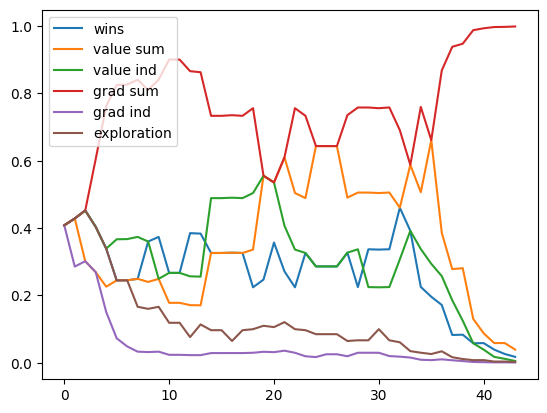

In [24]:
for j, lab in zip(range(6), ['wins', 'value sum', 'value ind', 'grad sum', 'grad ind', 'exploration']):
    plt.plot([i[j] for i in factor_hist], label=lab)
plt.legend()
plt.show()

In [ ]:
# 

In [82]:
import torch.autograd.functional as F

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(12 * 8 * 8, 1)

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        return self.fc(x_flat)


# Create an instance of the model
test_model = SimpleModel()

# Generate some input data (vectorized version)
batch_size = 10
vectorized_input = torch.ones((batch_size, 12, 8, 8), requires_grad=True).view(batch_size, -1)
jacobian_matrix = F.jacobian(lambda x: model(x.view(-1, 12, 8, 8)).sum(), vectorized_input)
jacobian = jacobian_matrix.view(batch_size, 12, 8, 8)

print("Jacobian shape:", jacobian.shape)


torch.Size([10, 768])
tensor(-14.8880, grad_fn=<SumBackward0>)
Jacobian shape: torch.Size([10, 12, 8, 8])


In [63]:
[i for i in test_model.parameters()]

[Parameter containing:
 tensor([[-0.2408, -0.2951, -0.0612, -0.0810]], requires_grad=True),
 Parameter containing:
 tensor([0.4001], requires_grad=True)]